In [79]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.optimizers import Adam
import optuna as op
import pickle
import matplotlib.pyplot as plt
import json
import plotly
print("TensorFlow version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.7.0
[]


In [80]:
dataset = pd.read_csv("./../../datasets/all.csv")

# shuffle rows
dataset = dataset.sample(frac=1).reset_index(drop=True)

# IMPOR 
X = pd.DataFrame()
for col in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday", "SchoolHoliday", "January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December", "Cars-Total", "diesel", "wind_meters_per_second", "rain_millimeters", "Number of vessels", "DaySin", "DayCos", "WeekSin", "WeekCos", "MonthSin", "MonthCos", "YearSin", "YearCos"]:
    X[col] = dataset[col].astype(float)
    X_hash = pd.util.hash_pandas_object(X, index=False)

X["Cars-Total"] = X["Cars-Total"] / 1000
X["diesel"] = X["diesel"] / 1
X["wind_meters_per_second"] = X["wind_meters_per_second"] / 10


Y = pd.DataFrame()
for col in ["NO2-ug-per-m3"]:
    Y[col] = dataset[col].astype(float)


# split into train and test
train_quota = 0.7
X_train = X[:int(len(X) * train_quota)]
X_test = X[int(len(X) * train_quota):]
Y_train = Y[:int(len(Y) * train_quota)]
Y_test = Y[int(len(Y) * train_quota):]

print(X.head())
print(Y.head())



   Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  \
0     0.0      1.0        0.0       0.0     0.0       0.0     0.0   
1     1.0      0.0        0.0       0.0     0.0       0.0     0.0   
2     0.0      0.0        0.0       0.0     1.0       0.0     0.0   
3     0.0      0.0        0.0       0.0     0.0       1.0     0.0   
4     1.0      0.0        0.0       0.0     0.0       0.0     0.0   

   SchoolHoliday  January  February  ...  rain_millimeters  Number of vessels  \
0            1.0      0.0       0.0  ...               0.0                0.0   
1            0.0      0.0       0.0  ...               0.0                4.0   
2            1.0      0.0       0.0  ...               0.0                5.0   
3            0.0      0.0       0.0  ...               0.0                6.0   
4            0.0      0.0       0.0  ...               0.0                7.0   

     DaySin        DayCos   WeekSin   WeekCos  MonthSin  MonthCos  \
0  0.965926 -2.588190e-01  0.

In [81]:
# set trining duration
epochs_per_batch = 3

def std(model):
    stds = []
    predictions = model.predict(X_test.to_numpy())
    predictions = np.abs(predictions - Y_test.to_numpy()) / Y_test.to_numpy()
    for guesses in predictions[0, :]:
        guesses = np.sort(predictions[:, 0])
        stds.append(guesses[int(len(guesses) * 0.682)])

    std = np.mean(np.array(stds))

    return std
# 1. Define an objective function to be maximized.
def objective(trial):

    activations = ['relu', 'linear', 'sigmoid', 'tanh']
    
    model = tf.keras.Sequential()
    model.add(Dense(X.shape[1], activation=trial.suggest_categorical('layer_in_activation', activations)))

    # 2. hyper parameters
    batch_size = trial.suggest_int("batch_size", 5, 2000)
    epochs = epochs_per_batch * batch_size
    learning_rate = trial.suggest_float("learning_rate", 0.00001, 1.0, log=True)
    
    model.add(Dense(trial.suggest_int("layer_1_neurons", 0, 50), activation=trial.suggest_categorical('layer_1_activation', activations)))
    model.add(Dense(trial.suggest_int("layer_2_neurons", 0, 50), activation=trial.suggest_categorical('layer_2_activation', activations)))
    model.add(Dense(Y.shape[1], activation=trial.suggest_categorical('layer_out_activation', activations)))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse')


    model.fit(
        X_train.to_numpy(),
        Y_train.to_numpy(),
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.0,
        verbose=0
    )

    return std(model)
    

In [82]:
# Get study name
X_hash = pd.util.hash_pandas_object(X, index=False).to_numpy().sum()
Y_hash = pd.util.hash_pandas_object(Y, index=False).to_numpy().sum()
study_name = "Optunia_study_"+str(epochs_per_batch)+"_"+str(X_hash)+"_"+str(Y_hash)+".pickle"

# Load Study
study = None
try:
    with open(study_name, 'rb') as f:
        study = pickle.load(f)
        print("Loaded study", study_name)
        print("Best trial:", study.best_trial)
except:
    study = op.create_study(direction='minimize')
    print("Created study", study_name)

Loaded study Optunia_study_3_8459435593110834926_10519735596490455367.pickle
Best trial: FrozenTrial(number=151, values=[0.3067876843438632], datetime_start=datetime.datetime(2022, 1, 25, 17, 40, 33, 124317), datetime_complete=datetime.datetime(2022, 1, 25, 17, 41, 9, 207933), params={'layer_in_activation': 'tanh', 'batch_size': 1563, 'learning_rate': 0.001138675229377315, 'layer_1_neurons': 47, 'layer_1_activation': 'tanh', 'layer_2_neurons': 41, 'layer_2_activation': 'sigmoid', 'layer_out_activation': 'linear'}, distributions={'layer_in_activation': CategoricalDistribution(choices=('relu', 'linear', 'sigmoid', 'tanh')), 'batch_size': IntUniformDistribution(high=2000, low=5, step=1), 'learning_rate': LogUniformDistribution(high=1.0, low=1e-05), 'layer_1_neurons': IntUniformDistribution(high=50, low=0, step=1), 'layer_1_activation': CategoricalDistribution(choices=('relu', 'linear', 'sigmoid', 'tanh')), 'layer_2_neurons': IntUniformDistribution(high=50, low=0, step=1), 'layer_2_activat

In [83]:
op.visualization.plot_optimization_history(study)       

In [84]:
df = study.trials_dataframe()

# get row with lowes "value" from df
best_trial = df.loc[df['value'].idxmin()]
best_trials_params = best_trial.to_dict()
# iterate each parameter and print it
for key, value in best_trials_params.items():
    # pad key with spaces
    key = key.ljust(30)
    print(key, ":", value)

number                         : 151
value                          : 0.3067876843438632
datetime_start                 : 2022-01-25 17:40:33.124317
datetime_complete              : 2022-01-25 17:41:09.207933
duration                       : 0 days 00:00:36.083616
params_batch_size              : 1563
params_layer_1_activation      : tanh
params_layer_1_neurons         : 47
params_layer_2_activation      : sigmoid
params_layer_2_neurons         : 41
params_layer_in_activation     : tanh
params_layer_out_activation    : linear
params_learning_rate           : 0.001138675229377315
state                          : COMPLETE


In [85]:
op.visualization.plot_slice(study)

In [86]:
op.visualization.plot_contour(study, params=['layer_1_neurons', 'layer_2_neurons'])

In [87]:
# optimize hyperparameters

while True:
    study.optimize(objective, n_trials=1)
    with open(study_name, 'wb') as f:
        pickle.dump(study, f)

KeyboardInterrupt: 

In [104]:
# Make a model from the best trial and train it longer

def get_model(trial_row):
    model = tf.keras.Sequential()
    model.add(Dense(X.shape[1], trial_row['params_layer_in_activation']))
    
    model.add(Dense(trial_row['params_layer_1_neurons'], activation=trial_row['params_layer_1_activation']))
    model.add(Dense(trial_row['params_layer_2_neurons'], activation=trial_row['params_layer_2_activation']))
    model.add(Dense(Y.shape[1], activation=trial_row['params_layer_out_activation']))

    model.compile(
        optimizer=Adam(learning_rate=trial_row['params_learning_rate']),
        loss='mse',
        metrics=['mean_absolute_error'])

    return model

trial_row = study.trials_dataframe().loc[study.best_trial.number]
model = get_model(trial_row)
history = model.fit(
        X_train.to_numpy(),
        Y_train.to_numpy(),
        batch_size=trial_row['params_batch_size'],
        epochs=trial_row['params_batch_size']*3,
        validation_split=0.0,
        verbose=0
    )

0.3253615379333496
5.180217742919922


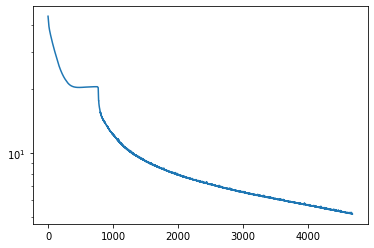

In [107]:
print(std(model))
print(history.history['mean_absolute_error'][-1])

# plot los
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(history.history['mean_absolute_error'])
ax.set_yscale('log');


In [108]:
history = model.fit(
        X_train.to_numpy(),
        Y_train.to_numpy(),
        batch_size=trial_row['params_batch_size'],
        epochs=trial_row['params_batch_size']*10,
        validation_split=0.0,
        verbose=0
    )


In [ ]:
print(std(model))
print(history.history['mean_absolute_error'][-1])

# plot los
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(history.history['mean_absolute_error'])
ax.set_yscale('log');



In [ ]:
model.summary()